<h2>Cleaning Data</h2>
Deze jupyter notebook file is gemaakt om de ruwe data die is aangeleverd door de gemeente, om te toveren naar een final dataset, waar een van de drie algoritshm meeteen mee aan de slag kan.
Dit is allemaal beschreven in Data Cleaning in mijn thesis


In [1]:
# Import needed packages
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot
from imblearn.under_sampling import RandomUnderSampler
import seaborn

In [2]:
## import the "raw" data
bbgaPD = pd.read_excel("C:\\VERTROUWELIJK\\2020_BBGA_0907.xlsx", engine='openpyxl')
youthCareData = pd.read_excel("C:\\VERTROUWELIJK\\20200902-Studentbegeleiding-JHoenderdos-Input-Hashed.xlsx", engine='openpyxl')

In [3]:
# Place to variables
jarenVanData = [2018,2019]

In [4]:
# Place to make functions
def calculateAge(born):
    today = datetime.date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

Onderstaande code is gemaakt voor het kopje "Youth care data" in mijn thesis. Hiermee is het mogelijk om de EDA te doen om de ruwe data. Uit onderstaande code komt dat ook de gegevens die nodig zijn voor tabel 1

In [5]:
## Describe the raw YouthCare data
youthCareData2018 = youthCareData[(youthCareData['Betrekking Op Jaar'] == 2018)]
youthCareData2018['Datum Geboorte'] = pd.to_datetime(youthCareData2018['Datum Geboorte'], format="%Y-%m-%d")
youthCareData2018['Leeftijd'] = youthCareData2018['Datum Geboorte'].apply(lambda x: calculateAge(x))

youthCareData2019 = youthCareData[(youthCareData['Betrekking Op Jaar'] == 2019)]
youthCareData2019['Datum Geboorte'] = pd.to_datetime(youthCareData2019['Datum Geboorte'], format="%Y-%m-%d")
youthCareData2019['Leeftijd'] = youthCareData2019['Datum Geboorte'].apply(lambda x: calculateAge(x))

number_of_rows_2018 = len(youthCareData2018.index)
number_of_rows_2019 = len(youthCareData2019.index)
uniqueID2018 = len(youthCareData2018['hashID'].unique())
uniqueID2019 = len(youthCareData2019['hashID'].unique())

averageAge2018 = youthCareData2018['Leeftijd'].mean()
averageAge2019 = youthCareData2019['Leeftijd'].mean()

sex2018 = youthCareData2018['Geslacht'].value_counts()
sex2019 = youthCareData2019['Geslacht'].value_counts()


C:\Users\jopho\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jopho\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\jopho\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [6]:
# BBGA data
bbgaPD = bbgaPD[(bbgaPD["niveaunaam"] == "4-cijferige postcode") & (bbgaPD.jaar.isin(jarenVanData))]
bbgaPD = bbgaPD.dropna(axis=1, how='all')

# for merging purposes, we change the name of one column
bbgaPD =bbgaPD.rename(columns = {'gebiedcode15':'Postcode'})
bbgaPD['Postcode'] = bbgaPD['Postcode'].astype(str).astype(int)

# removing colums, were there was to much NA values. 
bbgaPD = bbgaPD.drop([ 'niveau' , 'niveaunaam' , 'gebiedcodenaam','gebiednaam'], axis=1)


In [7]:
# YouthCare Data
# Filter to get only data beloning to the right year
youthCareData = youthCareData[(youthCareData['Betrekking Op Jaar'].isin(jarenVanData))]

# remove all non digits in order to get Postcode4
youthCareData = youthCareData[youthCareData.Postcode != 'xxxxx']
youthCareData['Postcode'] = youthCareData['Postcode'].str.extract('(\d+)', expand=False)


# add extra colum to caluclate age in order te group persons better
youthCareData['Datum Geboorte'] = pd.to_datetime(youthCareData['Datum Geboorte'], format="%Y-%m-%d")
youthCareData['Leeftijd'] = youthCareData['Datum Geboorte'].apply(lambda x: calculateAge(x))
youthCareData['Postcode'] = youthCareData['Postcode'].astype(str).astype(int)


# Add regex in order to filter only real voorziening data
pat = '^[B|C][0-9][A-Z]{1,2}$'
youthCareData['VoorziningenRegex'] = youthCareData.Voorziening.str.contains(pat)
youthCareData = youthCareData[youthCareData['VoorziningenRegex'] == True]
youthCareData['Geslacht'] =youthCareData['Geslacht'].replace(['M', 'V'], [0,1])

youthCareData =youthCareData.rename(columns = {'Betrekking Op Jaar':'jaar'})

In onderstaande regels worden de twee data sets, youth cara en de bbga dataset met elkaar gemerged. Zoals in mijn thesis beschreven is, gebeurt dit op basis van de 4cijfere postcode

In [8]:
merged_dataRegex = pd.merge(youthCareData, bbgaPD, on=['Postcode', 'jaar'], how='inner')

Omdat de data set imbalaced is, is ervoor gekozen om om alleen de bovenste 95% van de data te pakken. Hoe en waarom, is beschreven in mijn thesis onder het kopje "Data Cleaning". Ook zorgt dit er voor dat de data niet tot 1 persoon herleidt kan worden. Met de gemeente is er namelijk afgesproken dat er op zijn mintens 10 personen per catogorie moeten zitten. 

In [9]:
# create the final data set with 95% of the upper samples

Amount_of_Samples_delete = len(merged_dataRegex)-round(len(merged_dataRegex)*0.95)
overviewRegexAscendig = merged_dataRegex['Voorziening'].value_counts( ascending=True)
samplesToBeDeleted = pd.Series([])

sum = 0;
i = 0;
index = 0;

for i in overviewRegexAscendig:
    index = index + 1;
    sum = i + sum;
    
    if(sum < Amount_of_Samples_delete):
        continue;
    else:
        samplesToBeDeleted = overviewRegexAscendig[0:index];
        break;
        
tempdf = samplesToBeDeleted.to_frame()

tempdf = tempdf.reset_index()
serviceNamesToBeDeleted = tempdf['index'].tolist()
finalDataSet = merged_dataRegex[~merged_dataRegex['Voorziening'].isin(serviceNamesToBeDeleted)]
finalDataSet = finalDataSet.reset_index(drop=True)

finaldataset2018 = finalDataSet[(finalDataSet['jaar'] == 2018)]
finaldataset2019 = finalDataSet[(finalDataSet['jaar'] == 2019)]

# removing last variables which does not help in making the model
finalDataSet = finalDataSet.drop(['hashID', 'Datum Geboorte', 'Productcategorie', 'Voorzieningsoort', 'Productcategorie', 'jaar', 'VoorziningenRegex', 'jaar' ], axis=1)

finalDataSet = finalDataSet.fillna(0);

C:\Users\jopho\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


Als gezegd, mag de data niet te veel privacy gevoelig info gevatten. Hier is dan ook de aantal regels per services te zien. Dit mag niet onder de 10 per service komen.

In [10]:
finalDataSet['Voorziening'].value_counts()

B5I     2561
B5DZ    2161
C6DL    1136
B5P      839
B2I      749
C6DZ     609
C6I      454
B2DZ     453
B4DZ     371
C5DL     368
C5I      338
C5P      335
B5DL     333
C8DZ     332
C8DL     294
B4I      284
B6DZ     282
C5DZ     281
B2P      242
B8DZ     228
C4I      223
B1I      197
C4DZ     189
B6I      160
C2P      156
C2I      153
C1I      146
C4DL     140
C3DZ     128
B2DL     104
C2DL      97
B6DL      90
C2DZ      86
C6P       84
B7DZ      83
C8I       72
C8DM      68
Name: Voorziening, dtype: int64

Figuur 3 geeft een idee van de imbalance data set, en op welke threshold wij de data hebben gefilterd. Onderstaande code maakt dit figuur. 

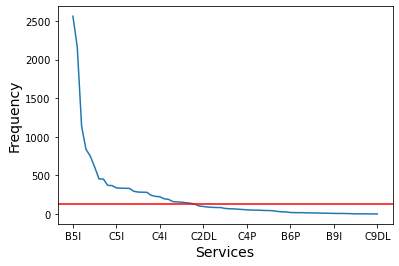

In [11]:
## make an plot for the report
overviewRegex = merged_dataRegex['Voorziening'].value_counts()
fig = plt.figure()
plot = overviewRegex.plot.line()
plot.axhline(y=132, color='r', linestyle='-')
plot.set_xlabel('Services', fontsize=14)
plot.set_ylabel('Frequency', fontsize=14)
fig.add_subplot(plot)
fig.savefig('full_figure.png')

Summarize distribution of the dependent variabele. This in oder for making an figure which can be seen in the report in figure 4

In [12]:
y = LabelEncoder().fit_transform(finalDataSet['Voorziening'])

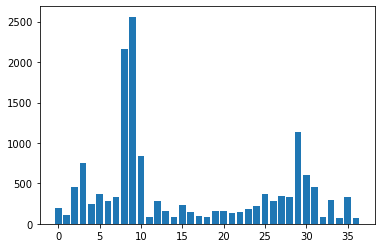

In [13]:
counter = Counter(y)
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

Visualize the result of undersampling the data

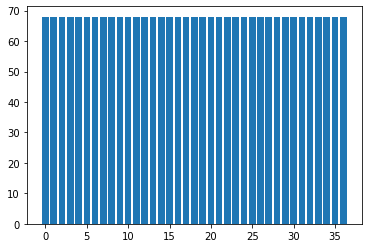

In [14]:
rus = RandomUnderSampler(random_state=0)
X = finalDataSet.drop(['Voorziening'], axis=1)
X_resampled, y_resampled = rus.fit_resample(X, y)

y_resampled = LabelEncoder().fit_transform(y_resampled)
counter = Counter(y_resampled)
fig = plt.figure()
pyplot.bar(counter.keys(), counter.values())
pyplot.savefig('RandomUnderSampleVisualize.png')

Create histogrammen of all avaible variables in the histogram

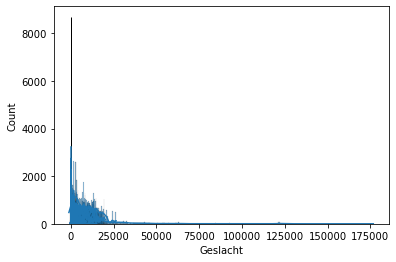

In [15]:
for i in X.columns:
    plaatje = seaborn.histplot(X[i],kde=True)
    naamplaatje = 'C:\\Users\\jopho\\Google Drive\\Master\\UvA\\Thesis\\MasterThesis GIT\\histogrammen\\' + str(i) + '.png'
    plaatje.figure.savefig(naamplaatje)

Om de final set op te slaan, en deze in andere jupyter notebook files gebruikt kan worden, wordt deze buiten deze jupyter notebook file opgeslagen. Eenmalig runnen van deze file is dan ook voldoende.

In [16]:
finalDataSet.to_pickle("C:\\VERTROUWELIJK\\final_dataSet.pkl")